##  A Fourier spectral solver for the heat equation

### The heat equation
Next, we discuss how we can combine the Fourier spectral method with
the time-stepping methods we have discussed in the previous
notebooks.  We will consider the heat equation

$$
\partial_t u(x,y,t) - \kappa \Delta u(x, y, t)  = g(x,y,t), \quad (x,y) \in \Omega, \quad t \in (0,T),
$$ (fou:eq:heat)

As before, the problem is to be solved on a given rectangular domain
$\Omega = [0,L_x) \times [0,L_y) \subset \mathbb{R}^2$ with periodic
boundary conditions, i.e.  the same considerations as for the
Poisson equation apply.
Moreover, the problem is supplemented with
**initial conditions** $u(0,x,y) = u_0(x,y)$, which we also assume to
satisfy the periodic boundary conditions.

Here, the unknown function $u$ represents the temperature distribution,
and $\kappa$ is the thermal diffusivity which assume to be constant.  
The right-hand side $g$ is a given heat source. 

Physically, the heat equation can be derived from energy conservation
principles. One start from the assumption that change of the total (heat-related) energy
in any given domain $\Omega$ is equal to the total heat flux $\mathbf{q}$ into the domain
and energy produced by a volumetric heat source.  This leads to the equation

$$
\frac{d}{dt} \int_\Omega u \,\mathrm{d}V = - \int_{\partial \Omega}  \mathbf{q} \cdot n \, \mathrm{d}S + \int_\Omega g \, \mathrm{d}V,
$$
Here the sign is chosen such that the right-hand side is positive when heat is entering into the domain through the
surface.

Since the domain is constant, we can move the time derivative inside the integral.
Morover using the divergence theorem, we can rewrite the surface integral as a volume integral
to arrive at

$$
\int_\Omega \partial_t u \,\mathrm{d}V = \int_{\partial \Omega} (g - \nabla \cdot \mathbf{q} )\, \mathrm{d}V
$$

Since the domain is arbitrary, we can conclude that the integrands must be equal, which leads us to

$$
\partial_t u + \nabla \cdot \mathbf{q} = g
$$

Finally, a constitutive relation between the heat flux $\mathbf{q}$ and the temperature gradient $\nabla u$ is needed. This is given by Fourier's law of heat conduction, which states that the heat flux can be expressed as
$\mathbf{q} = -\kappa \nabla u$, i .e. the flux is proportional to the temperature gradient, and the constant of proportionality is the thermal diffusivity $\kappa$. The sign is chosen such that heat flows from hot to cold regions. This leads to the heat equation

$$
\partial_t u -  \nabla \cdot(\kappa \nabla u) = \partial_t u - \kappa \Delta u = g
$$

if the diffusivity $\kappa$ is constant.

### A first attempt to solve the heat equation 

Assuming a rectangular domain $\Omega = [0,L_x) \times [0,L_y)$ and periodic boundary conditions, we can use the Fourier spectral method to solve the heat equation.
Developing both the solution the right-hand side in a Fourier series, and using the facts that

 * the Laplacian of a Fourier mode is proportional to the square of the wavenumber, and 
 * the operations $\partial_t(\cdot)$ and $\widehat{(\cdot)}$ commute for sufficiently well-behaving functions,

we find that 

$$
\widehat{\partial_t u}(k_x, k_y, t) = \partial_t \widehat{u}(k_x, k_y, t) = - \kappa |\mathbf{k}|^2 \widehat{u}(k_x, k_y, t) + \widehat{g}(k_x, k_y, t)
$$ (fou:eq:heat_fourier_space)

which is now just an ordinary differential equation for the Fourier coefficients $\widehat{u}$.
Here, $\mathbf{k} = (k_x, k_y)$ is the wavenumber vector, and $|\mathbf{k}|^2 = k_x^2 + k_y^2$.


Of course, when we discretize this equation in space, we use the discrete Fourier transform instead.
What kind of time-stepping method should we use? Let's try the simplest one, the **forward** or **explicit** Euler method, assuming a time step size of $\tau = T/N_t$.
That leads to the following scheme: Given the solution $\widehat{u}^n$ at time $t_n = n \tau$, we compute the right-hand side $g^n = g(x,y,t_n)$, and then we compute the Fourier coefficients $\widehat{u}^{n+1}$ at time $t_{n+1} = (n+1) \tau$ according to 

$$
\widehat{u}^{n+1}(k_x, k_y) = \widehat{u}^n(k_x, k_y) + \tau \left( - \kappa |\mathbf{k}|^2 \widehat{u}^n(k_x, k_y) + \widehat{g}^n(k_x, k_y) \right)
$$

Here, we use the short-hand notation $\widehat{g}^n(k_x, k_y) = \widehat{g}(k_x, k_y, t_n)$ for the Fourier coefficients of the right-hand side at time $t_n$. 
Let's implement this scheme in the following code snippet.


But wait a minute! The ODE {eq}`fou:eq:heat_fourier_space` looks very much like the test equation {ref}`stiff:ode:eq:exponential` we discussed in the previous notebook {ref}`ode:stiff-ode`!!
Indeed, if we set $\lambda = -\kappa |\mathbf{k}|^2$, we have exactly the same ODE!
What does that mean for our first attempt to solve the heat equation?

To guarantee that the forward Euler method remains stable during the time-stepping, we need to ensure that the time step size $\tau$ is chosen such that the stability condition

$$
\tau \leqslant 2/\lambda = 2/(\kappa |\mathbf{k}|^2)
$$.

In other words, whenever we double the number of grid points in each direction, we need to reduce the time step size 
to one fourth to keep the time-stepping stable!
This is a very severe restriction, and we need to find a better time-stepping method to solve the heat equation.
In the context of discretizing time-dependent PDEs, such conditions where the time step size is (severely) restricted by the space discretization parameter are known as the **CFL condition** (from the names of Courant, Friedrichs, and Lewy).

To avoid such a time step size restriction, we need to find a time-stepping method that is unconditionally stable, i.e. a method that does not depend on the time step size. One such method, namely the **backward** or **implicit** Euler method, we already discussed in the previous notebook {ref}`ode:stiff-ode`.
Applying this method to the heat equation, we arrive at the following scheme: Given the solution $\widehat{u}^n$ at time $t_n = n \tau$, we compute the right-hand side at $g^{n+1} = g(x,y,t_{n+1})$, and then we compute the Fourier coefficients $\widehat{u}^{n+1}$ at time $t_{n+1} = (n+1) \tau$ according to

$$
\widehat{u}^{n+1}(k_x, k_y) = \frac{\widehat{u}^n(k_x, k_y) + \tau \widehat{g}^{n+1}(k_x, k_y)}{1 + \tau \kappa |\mathbf{k}|^2}
$$  (fou:eq:heat_backward_euler)


Let's try this out! Conceptually, the implementation is very small step from our implementation of the Poisson solver, now we divide by $1 + \tau \kappa |\mathbf{k}|^2$ instead of dividing it by $|\mathbf{k}|^2$,
and we need to add a loop over the time steps.

In [5]:
%matplotlib widget
import numpy as np
from scipy.fft import fft2, ifft2, fft, fftfreq, fftshift, ifft, ifftshift

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation

import pandas as pd


In [2]:
def heat_backward_euler(*, kappa, 
                       X, Y, U0, 
                       t0, T, Nt, 
                       g=None):
    # Extract relevant grid data
    x, y = X[0,:], Y[:,0]
    Nx, Ny = len(x), len(y)
    if Nx < 2 or Ny < 2:
        raise ValueError("Grids must have at least two points in each space direction!")
    # Find space grid sampling size
    dx, dy = x[1] - x[0], y[1] - y[0]
    
    # Compute wave number grid
    kx = fftfreq(Nx, d=dx/(2*np.pi))
    ky = fftfreq(Ny, d=dy/(2*np.pi))
    KX, KY = np.meshgrid(kx, ky, sparse=True)
    
    # Compute multiplier for Poisson operator in Fourier space
    K2 = KX**2 + KY**2
    
    # Time stepping 
    t = t0 
    dt = (T-t0)/Nt
    
    # Store FFT of  solution together with t at each time step in a list
    # BAD PRACTICE: We should use a generator instead of a list, see below!
    U_list = []
    # Compute the FFT of the initial data 
    U_hat = fft2(U0)
    
    # For convenience and easier plotting and animation
    U_list.append((ifft2(U_hat).real, t))
    
    while t < T-dt/2:
        # Compute the right-hand side at t + dt in Fourier space
        if g is not None:
            G_hat = fft2(g(X,Y,t+dt))
        else:
            G_hat = 0
            
        # Compute solution in Fourier space and transform back to physical space
        U_hat = (U_hat + dt*G_hat)/(1+dt*kappa*K2)
        
        # Store current solution and time step 
        t = t + dt
        U_list.append((ifft2(U_hat).real, t))
        
    return U_list

In [3]:
def manufacture_solution_heat(u_str, kappa):
    import sympy as sy
    from sympy import sin, cos, exp
    x, y, t = sy.symbols('x y t')
    u_sy = eval(u_str)
    laplace = lambda u: sy.diff(u, x, x) + sy.diff(u, y, y)
    g_sy =  sy.diff(u_sy, t) - kappa*sy.simplify(laplace(u_sy))
    u = sy.lambdify((x, y, t), u_sy, modules='numpy')
    g = sy.lambdify((x, y, t), g_sy, modules='numpy')
    print(f'u = {u_sy}')
    print(f'u0 = {u_sy.subs(t, 0)}')
    print(f'g = {g_sy}')
    return u, g


In [4]:
# Example usage
kappa = 1
u_ex_str = 'sin(x)*cos(y)*exp(-2*kappa*t)'
u_ex, g = manufacture_solution_heat(u_ex_str, kappa)
# Set g to None if you rhs is 0 
g = None


u = exp(-2*t)*sin(x)*cos(y)
u0 = sin(x)*cos(y)
g = 0


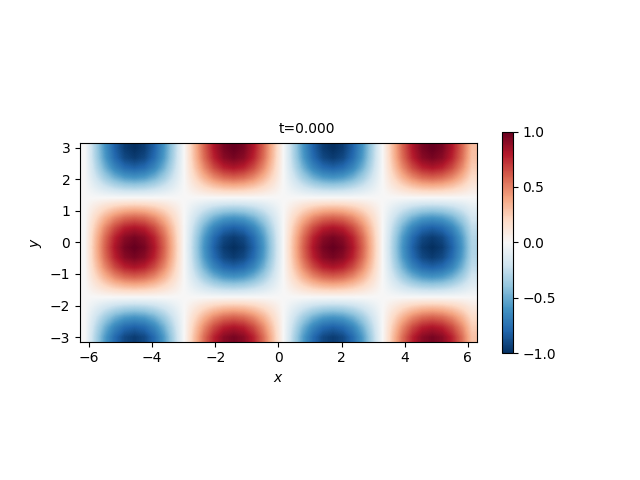

In [6]:
# Prepare grid and initial data
Lx, Ly = 4*np.pi, 2*np.pi
Nx, Ny = 40, 20
x = np.linspace(-Lx/2, Lx/2, Nx, endpoint=False)
y = np.linspace(-Ly/2, Ly/2, Ny, endpoint=False)
X, Y = np.meshgrid(x, y, sparse=True)
U0 = u_ex(X,Y,0)

t0, T = 0, 1
Nt = 10

plt.close('all')    
fig = plt.figure()
ax = fig.add_subplot(111)
img = ax.imshow(U0, cmap='RdBu_r', interpolation='bilinear', extent=[-Lx/2, Lx/2, -Ly/2, Ly/2])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
tx = ax.text(0,Ly/2*1.1,f"t={0.0:.3f}",
            bbox=dict(boxstyle="round",ec='white',fc='white'))
cbar = plt.colorbar(img, ax=ax, shrink=0.6)  # Adjust the shrink parameter to make the colorbar smaller
cbar.set_ticks(np.linspace(U0.min(), U0.max(), num=5))  # Set more ticks in the colorbar


In [7]:
import os
import os.path
import sys
# Add path to project_tools.py to Python's search path
project_tools_path = os.path.join(os.getcwd(), '../project_3_2025')
if project_tools_path not in sys.path:
    sys.path.append(project_tools_path)
import project_tools as pot


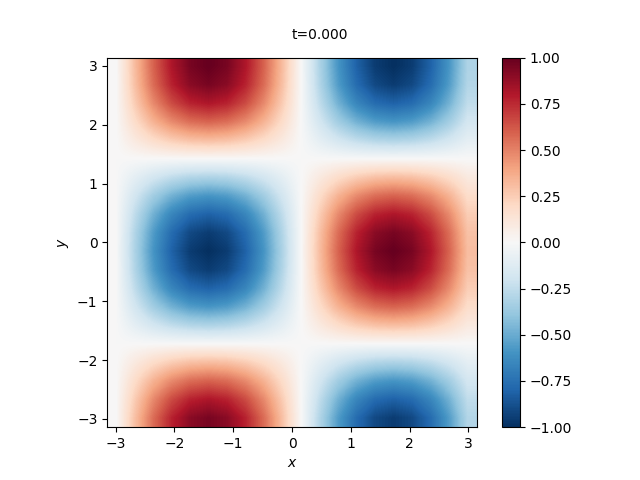

In [15]:
theta = 0.5
U_hat_list = heat_backward_euler(kappa=kappa, 
                                X=X, Y=Y, U0=U0, 
                                t0=t0, T=T, Nt=Nt, g=None)


ani = pot.create_animation(U_hat_list, Lx, Ly)


In [9]:
ani.to_jshtml()
from IPython.display import HTML
html_animation = ani.to_jshtml()
display(HTML(html_animation))


In [10]:
def compute_eoc_transient(*,
                          kappa, u_ex, U0, g,
                          X, Y, t0, T, Nt_list):
    errs_Nt = [] 
    for Nt in Nt_list:
        U_list = heat_backward_euler(kappa=kappa, 
                                     X=X, Y=Y, U0=U0, 
                                     t0=t0, T=T, Nt=Nt, 
                                     g=g)
        errs_t = []
        for U, t in U_list:
            U_ex = u_ex(X,Y,t)
            U_err = U - U_ex
            # Record maximum error at current time step
            errs_t.append(np.linalg.norm(U_err, np.inf))
        # Record maximum error over all time steps 
        errs_Nt.append(np.array(np.linalg.norm(errs_t, np.inf)))
        
    Nt_list = np.array(Nt_list)
    errs_Nt = np.array(errs_Nt)
    eocs = np.log(errs_Nt[1:]/errs_Nt[:-1])/np.log(Nt_list[:-1]/Nt_list[1:])
    eocs = np.insert(eocs, 0, np.inf)
    return errs_Nt, eocs


In [11]:
kappa = 1.0
u_ex_str = 'sin(x)*cos(y)*exp(-2*kappa*t)'
# u_ex_str = '(exp(1+sin(x)*sin(x))+exp(1+cos(y)*cos(y)))*exp(-4*kappa*t)'
u_ex, g = manufacture_solution_heat(u_ex_str, kappa)
# Set g to None if the manufactured solution does not have a source term
g = None


Lx, Ly = 2*np.pi, 2*np.pi
Nx, Ny = 20, 20
x = np.linspace(-Lx/2, Lx/2, Nx, endpoint=False)
y = np.linspace(-Ly/2, Ly/2, Ny, endpoint=False)
X, Y = np.meshgrid(x, y, sparse=True)
t0, T = 0, 1
U0 = u_ex(X,Y,0)

Nt_start = 10
Nt_refs = 6
# Alternative set of  time step numbers where 
# Nt = 20000 satisfies the CFL for theta = 0
# Nt_start = 10000
# Nt_refs = 3

Nt_list = [Nt_start*2**i for i in range(Nt_refs+1)]
print(Nt_list)


u = exp(-2.0*t)*sin(x)*cos(y)
u0 = sin(x)*cos(y)
g = 0
[10, 20, 40, 80, 160, 320, 640]


In [12]:
errs, eocs = compute_eoc_transient(kappa=kappa, 
                                   u_ex=u_ex, U0=U0, g=g,
                                   X=X, Y=Y, t0=t0, T=T, Nt_list=Nt_list)
table = pd.DataFrame({'Nt': Nt_list, 'error': errs, 'EOC': eocs})
display(table)


,Nt,error,EOC
0,10,0.429312,inf
1,20,0.223050,0.944656
2,40,0.113774,0.971194
3,80,0.057470,0.985292
4,160,0.028883,0.992567
5,320,0.014479,0.996263
6,640,0.007249,0.998127


### Implementation of time-stepping schemes using generator functions in Python

**What are generator functions in Python?** 
Any Python function that has the ```yield``` keyword in its body is a generator function: a
function which, when called, returns a generator object. (In other words, a generator
function is a generator factory.)
A generator function builds a generator object that wraps the body of the function.

Generators are iterators, but you can only iterate over them once. It's because they do not store all the values in memory, they generate the values on the fly. You use them by iterating over them, either with a 'for' loop or explicitly applying the 'next()' function.

For us, the main advantage of using generator functions is that they
allow us to write code that is more readable and more efficient as it
avoids the need to store all the time steps in memory. In project 3,
you will be asked to perform a time-stepping method that requires a
large number of time steps (4000) on a large grid (256x256). In this
case, storing all the time steps in memory would be very inefficient
and will highly likely lead to a memory error.

**Why not invert the IFFT at each time step?**
In the implementation below, we do not invert the IFFT at each time step. This is because the IFFT is despite its $\mathcal{O}(N)\log(N)$ complexity an expensive operation, and we want to avoid it as much as possible. Instead, we store the Fourier coefficients at each time step and invert the IFFT only if relevant, e.g. if we want to plot the solution at
certain time steps or compute a quantity of interest.

Let's implement the time-stepping schemes using generator functions in the following code snippet. We will also use the [`tqdm` package](https://pypi.org/project/tqdm/) to display a progress bar during the time-stepping.

In [74]:
from tqdm import tqdm

def heat_backward_euler_gen(*, kappa, 
                            X, Y, U0, 
                            t0, T, Nt, 
                            g=None):
    
    # Extract relevant grid data
    x, y = X[0,:], Y[:,0]
    Nx, Ny = len(x), len(y)
    if Nx < 2 or Ny < 2:
        raise ValueError("Grids must have at least two points in each space direction!")
    # Find space grid sampling size
    dx, dy = x[1] - x[0], y[1] - y[0]
    
    # Compute wave number grid
    kx = fftfreq(Nx, d=dx/(2*np.pi))
    ky = fftfreq(Ny, d=dy/(2*np.pi))
    KX, KY = np.meshgrid(kx, ky, sparse=True)
    
    # Compute multiplier for Biharmonic operator in Fourier space
    K2 = KX**2 + KY**2
    
    # Time stepping 
    t = t0 
    dt = (T-t0)/Nt
    
    # Compute the FFT of the initial data 
    U_hat = fft2(U0)
    
    # For convenience and easier plotting and animation,
    # we will yield the initial solution  before starting the time stepping
    yield (U_hat, t)
    
    with tqdm(total=T) as pbar:
        while t < T-dt/2:
            # Compute the right-hand side at t + theta dt in Fourier space
            if g is not None:
                # Store the old value of G_hat
                G_hat = fft2(g(X,Y,t+dt))
            else:
                G_hat = 0
                
            # Compute solution in Fourier space and transform back to physical space
            U_hat = (U_hat + dt*G_hat)/(1+dt*kappa*K2)
            
            t = t + dt
            pbar.update(dt)
            yield U_hat, t

In [83]:
# Prepare grid and initial data
Lx, Ly = 2*np.pi, 2*np.pi
Nx, Ny = 20, 20
x = np.linspace(-Lx/2, Lx/2, Nx, endpoint=False)
y = np.linspace(-Ly/2, Ly/2, Ny, endpoint=False)
X, Y = np.meshgrid(x, y, sparse=True)
U0 = u_ex(X,Y,0)

t0, T = 0, 1
Nt = 10

# The function call now does not return a list, but a generator!
solver  = heat_backward_euler_gen(kappa=kappa,
                                  X=X, Y=Y, U0=U0,
                                  t0=t0, T=T, Nt=Nt, g=None)
print(f"Solver is of type: {type(solver)}")

Solver is of type: <class 'generator'>


In [84]:
# We can now iterate over the generator to get the solution at each time step
for U_hat, t in solver:
    print(f"Time: {t:.3f}")
    U = ifft2(U_hat).real
    print(f"Max error at time step: {np.linalg.norm(U - u_ex(X,Y,t), np.inf)}")

Time: 0.000
Max error at time step: 3.332531350120987e-15


100%|█████████▉| 0.9999999999999999/1 [00:00<00:00, 1213.98it/s]

Time: 0.100
Max error at time step: 0.18439412641078134
Time: 0.200
Max error at time step: 0.3046309139884359
Time: 0.300
Max error at time step: 0.37746217429474016
Time: 0.400
Max error at time step: 0.41574945411391273
Time: 0.500
Max error at time step: 0.42931150023771447
Time: 0.600
Max error at time step: 0.4255943917107222
Time: 0.700
Max error at time step: 0.41020043667780204
Time: 0.800
Max error at time step: 0.38730472897306506
Time: 0.900
Max error at time step: 0.3599824728718905
Time: 1.000
Max error at time step: 0.330465538150201


In [85]:
Nt = 1000
# Take a snapshot every 10th solution for animation purposes
Nt_snap = Nt/100
# Try also this with snapshots every 1000th solution!
# Nt = 1000000
solver  = heat_backward_euler_gen(kappa=kappa,
                                  X=X, Y=Y, U0=U0,
                                  t0=t0, T=T, Nt=Nt, g=None)

U_snapshots = []
snap_counter = 0
for U_hat, t in solver:
    if snap_counter % Nt_snap == 0:
        U_snapshots.append((ifft2(U_hat).real, t))
    snap_counter += 1
print(f"Number of snapshots: {len(U_snapshots)}")

  0%|          | 0/1 [00:00<?, ?it/s]/Users/andrmas/.local/share/virtualenvs/tma4320_scientific_computation-vlMPykwy/lib/python3.13/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 1.0000000000000007/1 [00:00<00:00, 130.78it/s]

Number of snapshots: 101


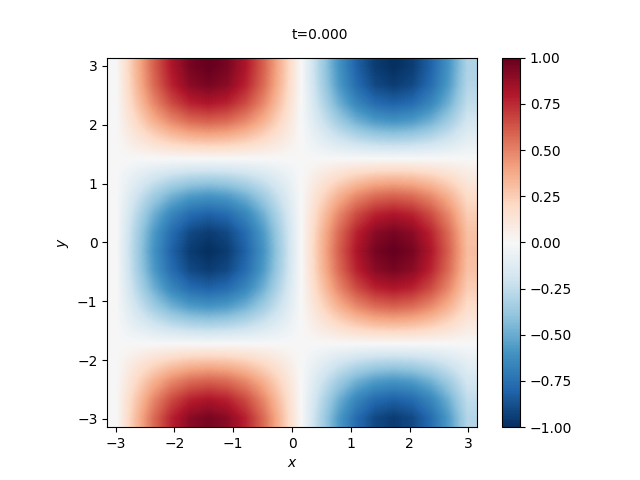

In [82]:
ani = pot.create_animation(U_snapshots, Lx, Ly)

In [ ]:
ani.to_jshtml()
from IPython.display import HTML
html_animation = ani.to_jshtml()
display(HTML(html_animation))